In [1]:
import numpy as np
import math
from math import pi as pi
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
%matplotlib notebook

In [2]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file("data2.nc")
###f = netcdf_file("04032020.nc")
##f = netcdf_file("04032019.nc")
f.variables

{'ugos': <scipy.io._netcdf.netcdf_variable at 0x7f84483ae820>,
 'vgos': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa173a0>,
 'vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa173d0>,
 'crs': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa17460>,
 'err_vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa174f0>,
 'latitude': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa175b0>,
 'nv': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa17640>,
 'sla': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa176d0>,
 'ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa17820>,
 'lat_bnds': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa17880>,
 'flag_ice': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa17910>,
 'adt': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa179d0>,
 'err_ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa17a30>,
 'tpa_correction': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa17ac0>,
 'time': <scipy.io._netcdf.netcdf_variable at 0x7f83cfa17b50>,
 'longitude': <scipy.io._n

In [3]:
long = f.variables['longitude'].data.copy()[10:40]
lat = f.variables['latitude'].data.copy()[60:82]

In [4]:
vel_x = f.variables['ugos'].data.squeeze()
print(vel_x.shape[0])
vel_y = f.variables['vgos'].data.squeeze()
print(vel_y.shape)

321
(321, 81)


In [5]:
print(f"Missing values in x: {np.isnan(np.amin(vel_x))}, at {np.argwhere(np.isnan(vel_x))}")
print(f"Missing values in y: {np.isnan(np.amin(vel_y))}, at {np.argwhere(np.isnan(vel_y))}")

Missing values in x: True, at [[150  23]]
Missing values in y: True, at [[150  23]]


In [6]:
from common_functions import interpolate_missing_point

imputed_vel_x = interpolate_missing_point(vel_x, np.ma.masked_invalid(vel_x).mask)[60:82,10:40]
imputed_vel_y = interpolate_missing_point(vel_y, np.ma.masked_invalid(vel_y).mask)[60:82,10:40]

<IPython.core.display.Javascript object>


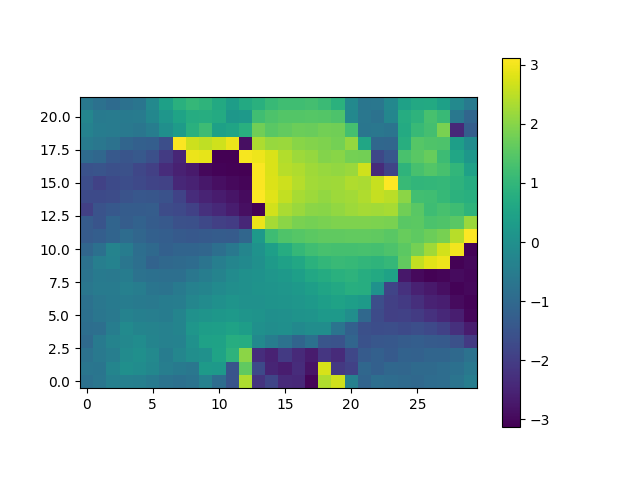

In [7]:
theta = np.arctan2(imputed_vel_y, imputed_vel_x)
plt.figure()
plt.imshow(theta, origin = 'lower')
plt.colorbar()

In [41]:
print(theta.shape)
print(imputed_vel_x.shape)

(22, 30)
(22, 30)


In [8]:
print("Size of grid in y direction is,", theta.shape[0])
print("Size of grind in x direction is,", theta.shape[1])

Size of grid in y direction is, 22
Size of grind in x direction is, 30


In [32]:
def calc_grid_direction(theta,i,j):
    #theta is angle in radians of the direction of the vector. Measured anticlockwise from the horizontal
    #i,j are the x,y indeces of the cell of the vector
    #returns output of the cell the vector is pointing to

    #Initialise output indices as same as current cell
    i_out = i
    j_out = j

    #Determine which region angle falls in
    if -np.pi/8 < theta <= np.pi/8:
        cell = 1
        j_out += 1
    elif np.pi/8 < theta <= 3*np.pi/8:
        cell = 2
        j_out += 1
        i_out += 1
    elif 3*np.pi/8 < theta <= 5*np.pi/8:
        cell = 3
        i_out += 1
    elif 5*np.pi/8 < theta <= 7*np.pi/8:
        cell = 4
        j_out -= 1
        i_out += 1
    elif 7*np.pi/8 < theta <= np.pi or -np.pi <= theta <= -7*np.pi/8:
        cell = 5
        j_out -= 1
    elif -7*np.pi/8 < theta <= -5*np.pi/8:
        cell = 6
        j_out -= 1
        i_out -= 1
    elif -5*np.pi/8 < theta <= -3*np.pi/8:
        cell = 7
        i_out -= 1
    elif -3*np.pi/8 < theta <= -np.pi/8:
        cell = 8
        j_out += 1
        i_out -= 1

    return cell,i_out,j_out

In [87]:
def streamline_calculator(i, j):

    #Initialise variables and lists
    visited_points = []
    n=0 #While loop counter
    visited_points.append([i,j]) #Initial starting coordinates

    phi = 0 #Winding angle
    winding_angle = [] #List to see how angle evolves over time
    

    while n < 10000:
        _, i_new, j_new = calc_grid_direction(theta[i,j], i, j)
        
        if i_new < 0 or j_new < 0:
            break
        if i == i_new and j == j_new:
            print("Bad")
            break
            
        alpha_1 = theta[i,j]
        try:
            alpha_2 = theta[i_new, j_new]
        except:
            break
        
        phi += alpha_1 - alpha_2
        winding_angle.append(phi)
    

        if phi%(2*pi) < 0.01:
            print("A full wind")
            if True:
                print(visited_points)
                return np.mean(visited_points, axis=0), visited_points
            
        visited_points.append([i_new, j_new])    
        i = i_new
        j = j_new
        n += 1   

In [91]:
m,n = imputed_vel_x.shape

centres = []

for i in range(0, m):
    for j in range(0, n):
        if (centre := streamline_calculator(i,j)) is not None:
            centres.append(centre)
            

A full wind
Possible eddy
Coordinates of loop: 0 11
[[1, 11]]
A full wind
Possible eddy
Coordinates of loop: 1 22
[[2, 22]]
A full wind
Possible eddy
Coordinates of loop: 4 15
[[4, 13], [4, 14]]
A full wind
Possible eddy
Coordinates of loop: 4 18
[[4, 17]]
A full wind
Possible eddy
Coordinates of loop: 6 13
[[6, 12]]
A full wind
Possible eddy
Coordinates of loop: 6 10
[[8, 12], [8, 13], [8, 14], [8, 15], [8, 16], [9, 17], [10, 18], [11, 18], [12, 18], [13, 18], [14, 17], [15, 16], [16, 15], [17, 14], [17, 13], [17, 12], [17, 11], [17, 10], [17, 9], [17, 8], [17, 7], [16, 6], [15, 5], [14, 5], [13, 5], [12, 5], [11, 5], [10, 5], [9, 6], [8, 7], [7, 8], [6, 9]]
A full wind
Possible eddy
Coordinates of loop: 6 12
[[8, 13], [8, 14], [8, 15], [8, 16], [9, 17], [10, 18], [11, 18], [12, 18], [13, 18], [14, 17], [15, 16], [16, 15], [17, 14], [17, 13], [17, 12], [17, 11], [17, 10], [17, 9], [17, 8], [17, 7], [16, 6], [15, 5], [14, 5], [13, 5], [12, 5], [11, 5], [10, 5], [9, 6], [8, 7], [7, 8], 

In [89]:
print(centres)
centres = np.asarray(centres)

[array([ 1., 11.]), array([ 2., 22.]), array([ 4. , 13.5]), array([ 4., 17.]), array([ 6., 12.]), array([12.40625, 11.15625]), array([12.15151515, 11.09090909]), array([ 8., 27.]), array([12.26923077, 10.92307692]), array([11.23529412, 11.29411765]), array([11., 25.]), array([11.13846154, 13.2       ]), array([11.03174603, 12.96825397]), array([10.90625, 13.78125]), array([10.85 , 13.875]), array([13., 20.]), array([10.37142857, 12.91428571]), array([16.5 , 24.75]), array([17., 11.]), array([17., 18.]), array([19.5, 24.5])]


<IPython.core.display.Javascript object>


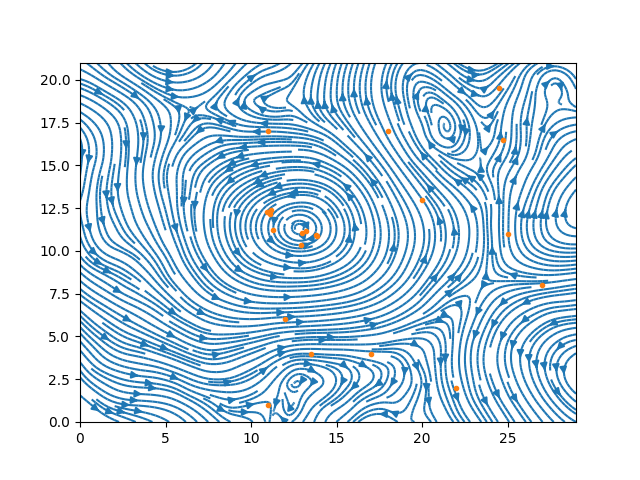

In [90]:
y = np.arange(0, theta.shape[0])
x = np.arange(0, theta.shape[1])

X, Y = np.meshgrid(x, y)

plt.figure()
plt.streamplot(X, Y, imputed_vel_x, imputed_vel_y, density = 3)
plt.plot(centres[:,1], centres[:,0],'.')
plt.gca().set_aspect('equal')
plt.show()